# Methodology (Machine Learning):
Pada bagian ini, kami akan membuat model yang dapat melakukan *customer segmentation*. *Customer segmentation* sendiri merupakan masalah *unsupervised* sehingga data kami tidak ada label, melainkan nanti kami sendiri yang akan memberikan label. Algoritma yang dapat digunakan:
- RFM Sementation
- K-Means
- Agglomerative Clustering

## Data (Machine Learning):
- Unit Analysis:
  - Customer behavior: Customer Unique ID

- Features:
  - Recency: Mengukur dari kapan terakhir kali seorang customer melakukan transaksi.  

  - Frequency: Mengukur dari seberapa sering seorang customer melakukan transaksi.

  - Monetary: Mengukur dari total transaksi yang dilakukan seorang customer.

## RFM Segmentation 
RFM adalah singkatan dari *Recency, Frequency,* dan *Monetary*. Tiap faktor menyesuaikan dengan ciri-ciri dari *customer*. Metrik RFM ini merupakan indikator penting dari segmentasi perilaku *customer* karena *frequency* dan *monetary* memengaruhi *customer lifetime value*, dan *recency* memengaruhi *engagement rate.*



In [ ]:
# Data
import pandas as pd
import numpy as np
import datetime as dt

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn')

# Modeling
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Evaluation
from sklearn.metrics import silhouette_score

#Scaling
from sklearn.preprocessing import StandardScaler

# Regular Expression
import re

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Data
cust_df = pd.read_csv('/content/drive/MyDrive/Project Purwadhika/customer.csv')

In [ ]:
cust_df.head()

customer_unique_id  recency  ...  most_product_buy  first_transaction
0  0000366f3b9a7992bf8c76cfdf3221e2      117  ...    bed_bath_table            2018-05
1  0000b849f77a49e4a4ce2b2a4ca5be3f      120  ...     health_beauty            2018-05
2  0000f46a3911fa3c0805444483337064      543  ...        stationery            2017-03
3  0000f6ccb0745a6a4b88665a16c9f078      327  ...         telephony            2017-10
4  0004aac84e0df4da2b147fca70cf8255      294  ...         telephony            2017-11

[5 rows x 9 columns]

### Recency Segmentation
*Recency* merupakan perhitungan waktu terakhir seorang *customer* melakukan transaksi dalam satuan hari. Segmentasi berdasarkan *recency* ini dilakukan dengan membuat kelompok berdasarkan nilai *quartile* (Q1, Q2, dan Q3) sehingga terdapat 4 kelompok. Nama dari kelompok tersebut adalah *active, warm, cold,* dan *inactive* yang diambil berdasarkan *market temperature*.     

#### Scoring

In [ ]:
# Calculate Q1, Q2, Q3 from Recency
cust_df['recency'].quantile([0.25, 0.5, 0.75])

0.25    120.0
0.50    224.0
0.75    353.0
Name: recency, dtype: float64

In [ ]:
# Recency Segmentation using quartile and scoring
label_r = range(4, 0, -1)
group_r = pd.qcut(cust_df['recency'], q=4, labels=label_r).astype('int')
cust_df['R'] = group_r.values

In [ ]:
# Group by R
df_R = cust_df.groupby(['R']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index(drop = False)

# Name the R segment
df_R.loc[df_R['R'] == 4, 'R_group'] = 'active'
df_R.loc[df_R['R'] == 3, 'R_group'] = 'warm'
df_R.loc[df_R['R'] == 2, 'R_group'] = 'cold'
df_R.loc[df_R['R'] == 1, 'R_group'] = 'innactive'

# Calculate the percentage
df_R['R_percent'] = round(df_R['n_customers']/df_R['n_customers'].sum()*100, 2)

df_R

R  n_customers    R_group  R_percent
0  1        23440  innactive      24.91
1  2        23563       cold      25.04
2  3        23318       warm      24.78
3  4        23766     active      25.26

> Keterangan :
> - *Active* = *Recency* -nya lebih kecil atau sama dengan dari 120 (Q1) / kurang dari 4 bulan
- *Warm* = *Recency* -nya diantara 121 - 224 (Q2) / 4 - 7 bulan
- *Cold* = *Recency* -nya diantara 225 - 353 (Q3 / 7 - 11 bulan
- *Inactive* = *Recency* -nya lebih dari 353 (Q3) / lebih dari 11 bulan

#### Visualization

In [ ]:
recency_cust = cust_df['customer_unique_id'].groupby(cust_df['recency']).count()

# Visualization
fig = go.Figure()
# Create Layout
fig.update_layout(
    title='Recency Segmentation',
    xaxis_title='Days (since last transactions)',
    yaxis_title='Total Customers',
    showlegend=False)
# Plot Area Chart
fig.add_trace(go.Scatter(x=recency_cust.index, 
                         y=recency_cust.values, 
                         fill='tozeroy', 
                         mode='none'))
# Plot Line
fig.add_trace(go.Scatter(x=[120, 120], y=[0,1100], 
                         mode="lines", 
                         marker=dict(size=12, line=dict(width=0.8),color='navy'), 
                         name='Q1 (120 days)'))
fig.add_trace(go.Scatter(x=[224, 224], y=[0,1100], 
                         mode="lines", 
                         marker=dict(size=12, line=dict(width=0.8),color='navy'), 
                         name='Q2 (224 days)'))
fig.add_trace(go.Scatter(x=[353, 353], y=[0,1100], 
                         mode="lines", 
                         marker=dict(size=12, line=dict(width=0.8),color='navy'), 
                         name='Q3 (353 days)'))
# Annotation
fig.add_annotation(x=60, y=1000,
            text="Active: 25.26 %",
            showarrow=False,
            yshift=10)

fig.add_annotation(x=173, y=1000,
            text="Warm: 24.78 %",
            showarrow=False,
            yshift=10)

fig.add_annotation(x=290, y=1000,
            text="Cold: 25.04 %",
            showarrow=False,
            yshift=10)

fig.add_annotation(x=450, y=1000,
            text="Inactive:  24.91 %",
            showarrow=False,
            yshift=10)
fig.show()

> Berdasarkan grafik diatas dapat terlihat pembagian segmentasi *customer* berdasarkan nilai *recency*-nya. Terdapat 4 segmen yaitu: 
- *Active* : Terdapat 23,766 *customer* atau 25.26 % *customer* yang melakukan transaksi dibawah 120 hari
- *Warm* : Terdapat 23,318 *customer* atau 24.78 % *customer* yang melakukan transaksi diantara 112 - 224 hari
- *Cold* : Terdapat 23,563 *customer* atau 25.04 % *customer* yang melakukan transaksi diantara 225 - 353 hari
- *Inactive* : Terdapat 23,440 *customer* atau 24.91 % *customer* yang melakukan transaksi diatas 353 hari

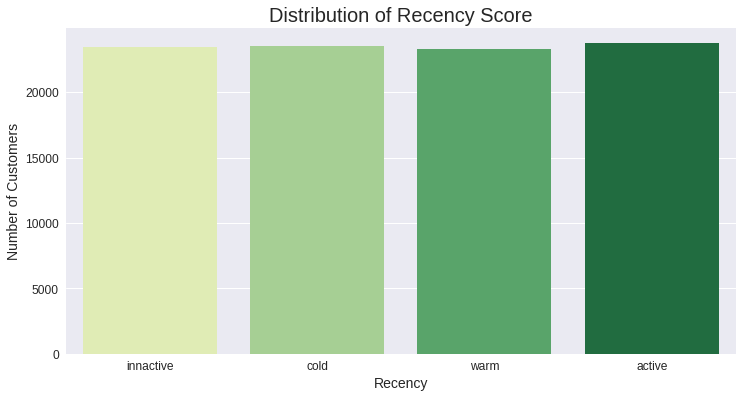

In [ ]:
# Distribution of Recency
plt.figure(figsize=(12, 6))
sns.barplot(x='R_group', y='n_customers', data=df_R, palette='YlGn')
plt.title('Distribution of Recency Score',fontsize=20)
plt.xlabel('Recency',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

> Berdasarkan grafik diatas, mayoritas *customer Olist* berada pada segmen *Active*. Hal ini berarti mereka aktif melakukan transaksi dibawah 120 hari sejak melakukan transaksi terakhir. 

>  Segmentasi berdasarkan *recency* ini penting karena semakin baru seorang *customer* melakukan transaksi di *Olist*, maka semakin besar kecendrungan bahwa ia akan mengingat *Olist* dan melakukan transaksi lagi, seperti pada segmen *Active*. 

### Frequency Segmentation
*Frequency* merupakan perhitungan seberapa sering seorang *customer* melakukan transaksi. Segmentasi berdasarkan *frequency* ini dilakukan dengan membuat 4 kelompok dengan cara mengurutkan *frequency* tiap customer lalu membagi 4 sama besar, cara ini digunakan karena mayoritas dari *customer* hanya melakukan transaksi sebanyak 1 kali sehingga nilainya akan condong ke yang paling banyak. Nama dari segmentasinya adalah *low frequency*, *medium frequency*, *high frequency*, dan *special frequency*.

#### Scoring

In [ ]:
# Frequency segmentation
def F_segmentation(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    else:
        return 4

cust_df['F'] = cust_df['frequency'].apply(F_segmentation)
cust_df['F'].value_counts()

1    91238
2     2617
3      185
4       47
Name: F, dtype: int64

In [ ]:
# Group by F
df_F = cust_df.groupby(['F']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index(drop = False)

# Name the F segmentation
df_F.loc[df_F['F'] == 4, 'F_group'] = 'special'
df_F.loc[df_F['F'] == 3, 'F_group'] = 'high'
df_F.loc[df_F['F'] == 2, 'F_group'] = 'medium'
df_F.loc[df_F['F'] == 1, 'F_group'] = 'low'

# Calculate the percentage
df_F['F_percent'] = round(df_F['n_customers']/df_F['n_customers'].sum()*100, 2)

df_F

F  n_customers  F_group  F_percent
0  1        91238      low      96.97
1  2         2617   medium       2.78
2  3          185     high       0.20
3  4           47  special       0.05

> Keterangan :
- Special Frequency : Lebih dari 4 kali melakukan transaksi
- High Frequency : 3 kali melakukan transaksi
- Medium Frequency : 2 kali melakukan transaksi
- Low Frequency : Hanya 1 kali melakukan transaksi 

#### Visualization

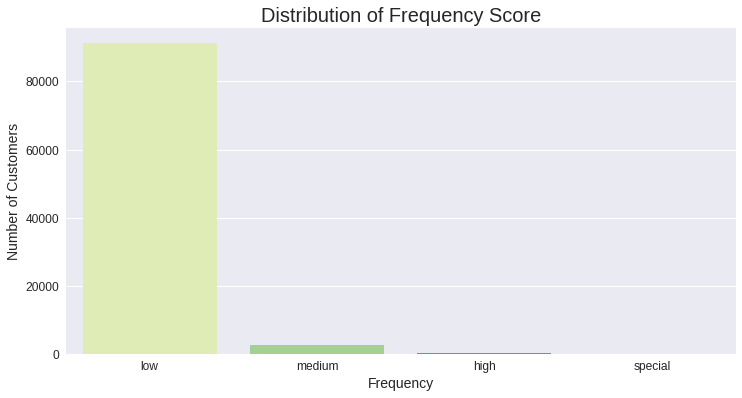

In [ ]:
# Distribution of Frquency
plt.figure(figsize=(12, 6))
sns.barplot(x='F_group', y='n_customers', data=df_F, palette='YlGn')
plt.title('Distribution of Frequency Score',fontsize=20)
plt.xlabel('Frequency',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

> Berdasarkan grafik diatas dapat terlihat pembagian segmentasi *customer* berdasarkan nilai *frequency*-nya. Terdapat 4 segmen yaitu: 
- *Special Frequency* : Terdapat 46 atau 0.05 % *customer* yang melakukan lebih dari 4 kali transaksi
- *High Frequency* : Terdapat 185 atau 0.2 % *customer* yang melakukan transaksi sebanyak 3 kali.
- *Medium Frequency* : Terdapat 2,617 atau 2.78 % *customer* yang melakukan transaksi sebanyak 2 kali
- *Low Frequency* : Terdapat 91,238 atau 96.97 % *customer* yang melakukan transaksi sebanyak 1 kali

> Mayoritas customer Olist berada pada segmen Low Frequency, yang artinya hanya melakukan transaksi sebanyak 1 kali saja.

> Dengan melakukan segmentasi berdasarkan frequency, kita dapat melihat customer mana yang menggunakan Olist berulang kali untuk melakukan transaksi atau dengan kata lain customer yang loyal dengan Olist.

### Monetary Segmentation
*Monetary* merupakan kekuatan belanja atau total pembelian dari seorang *customer*. Segmentasi berdasarkan *monetary* ini dilakukan dengan membuat kelompok berdasarkan nilai *quartile* (Q1, Q2, dan Q3) sehingga terdapat 4 kelompok. Nama dari segmentasinya adalah *low value*, *medium value*, *high value*, dan *special value*.

#### Scoring

In [ ]:
# Calculate Q1, Q2, Q3 from Monetary
round(cust_df['monetary'].quantile([0.25, 0.5, 0.75]))

0.25     64.0
0.50    113.0
0.75    203.0
Name: monetary, dtype: float64

In [ ]:
# Scoring for M values
labels_m = range(1, 5)
group_m = pd.qcut(cust_df['monetary'], q = 4, labels = labels_m).astype('int')
cust_df['M'] = group_m.values

In [ ]:
# Group by M
df_M = cust_df.groupby(['M']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index(drop = False)

# Name the M Segmentation
df_M.loc[df_M['M'] == 1, 'M_group'] = 'low values'
df_M.loc[df_M['M'] == 2, 'M_group'] = 'medium values'
df_M.loc[df_M['M'] == 3, 'M_group'] = 'high values'
df_M.loc[df_M['M'] == 4, 'M_group'] = 'special values'

# Calculate the percentage
df_M['M_percent'] = round(df_M['n_customers']/df_M['n_customers'].sum()*100, 2)

df_M

M  n_customers         M_group  M_percent
0  1        23588      low values      25.07
1  2        23456   medium values      24.93
2  3        23528     high values      25.01
3  4        23515  special values      24.99

> Keterangan :
> - *Special Values* = *Monetary*-nya lebih dari R\$ 203 (Q3)
- *High Values* = *Monetary*-nya diantara R\$ 113 (Q2) - R\$ 203
- *Medium Values* = *Monetary*-nya diantara R\$ 64 (Q1) - R\$ 112 
- *Low Values* = *Monetary*-nya kurang dari R\$ 64 

#### Visualization

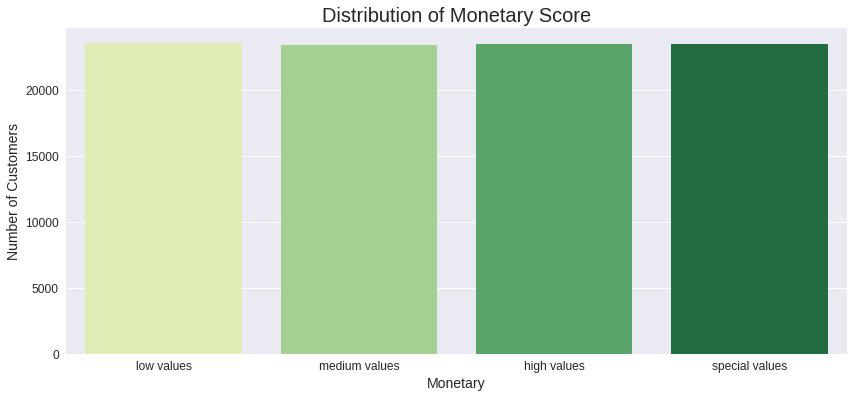

In [ ]:
# Distribution of Monetary
plt.figure(figsize=(14, 6))
sns.barplot(x='M_group', y='n_customers', data=df_M, palette='YlGn')
plt.title('Distribution of Monetary Score',fontsize=20)
plt.xlabel('Monetary',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

> Berdasarkan grafik diatas dapat terlihat pembagian segmentasi *customer* berdasarkan nilai *frequency*-nya. Terdapat 4 segmen yaitu: 
- *Special Values* : Terdapat 23,515 atau 24.99 % *customer* yang melakukan transaksi dengan total lebih dari R\$ 203
- *High Values* : Terdapat 23,528 atau 25.01 % *customer* yang melakukan transaksi dengan total R\$ 113 - R\$ 204
- *Medium Values* : Terdapat 23,456 atau 24.93 % *customer* yang melakukan transaksi dengan total R\$ 643 - R\$ 112
- *Low Values* : Terdapat 23,588 atau 23.07 % *customer* yang melakukan transaksi dengan total kurang dari R\$ 64

> Mayoritas customer Olist berada pada segmen High Values, yang artinya melakukan transaksi dengan total R\$ 113 - R\$ 204

> Dengan melakukan segmentasi berdasarkan monetary, kita dapat melihat customer mana yang melakukan jumlah transaksi paling besar dan paling sedikit. Dengan itu kita dapat melakukan pendekatan marketing yang berbeda sesuai segmennya.

### RFM Segmentation
Pada RFM Segmentation ini kami melakukan perhitungan skor segmentasinya dengan cara mengkombinasikan skor dari R, F, dan M menjadi sebuah kombinasi unik dalam bentuk string. Contohnya jika R = 1, F = 1, dan M = 1 maka RFM Segmentation Score nya menjadi 1 + 1 + 1 = 111



#### Calculate RFM Score

In [ ]:
# Combine the R, F, and M score
cust_df['RFM Score'] = cust_df['R'].astype(str) + cust_df['F'].astype(str) + cust_df['M'].astype(str)
cust_df['RFM Score']

0        413
1        411
2        112
3        211
4        213
        ... 
94082    114
94083    212
94084    112
94085    313
94086    112
Name: RFM Score, Length: 94087, dtype: object

#### RFM Segmentation based on the RFM Score

In [ ]:
# RFM Segmentation 
def segmentation(x):
    if re.search('444', x) or re.search('344', x): 
        return 'Best'
    elif re.search('2.4', x) or re.search('3.4', x) or re.search('4.4', x):
        return 'Big Spender'
    elif re.search('24.', x) or re.search('34.', x) or re.search('23.', x) or re.search('33.', x):
        return 'Loyal'
    elif re.search('41.', x):
        return 'New'
    elif re.search('4..', x) or re.search('3..', x):
        return 'Promising'
    elif re.search('111', x) or re.search('211', x) or re.search('112', x) or re.search('212', x):
        return 'Lost'
    elif re.search('1..', x) or re.search('2..', x):
        return 'Lost Potential'
    else:
        return 'Reguler'

cust_df['RFM Segment'] = cust_df['RFM Score'].apply(segmentation)
cust_df['RFM Segment'].value_counts()

Lost              23684
Promising         17732
Big Spender       17704
New               17499
Lost Potential    17413
Best                 37
Loyal                18
Name: RFM Segment, dtype: int64

In [ ]:
# Customer Segmentation Percentage
round(cust_df['RFM Segment'].value_counts(normalize=True)*100, 2)

Lost              25.17
Promising         18.85
Big Spender       18.82
New               18.60
Lost Potential    18.51
Best               0.04
Loyal              0.02
Name: RFM Segment, dtype: float64

In [ ]:
rfm_agg = cust_df.groupby('RFM Segment').agg({
    'recency' : 'mean',
    'frequency' : 'mean',
    'monetary' : 'mean',
    'RFM Segment' : 'count'
})

rfm_agg.round(2)

recency  frequency  monetary  RFM Segment
RFM Segment                                              
Best             101.32       5.00   1792.36           37
Big Spender      173.31       1.09    574.42        17704
Lost             370.29       1.00     65.12        23684
Lost Potential   400.25       1.05    286.16        17413
Loyal            198.39       3.00    165.54           18
New               62.91       1.00     94.28        17499
Promising        170.48       1.03     94.93        17732

#### Distribution

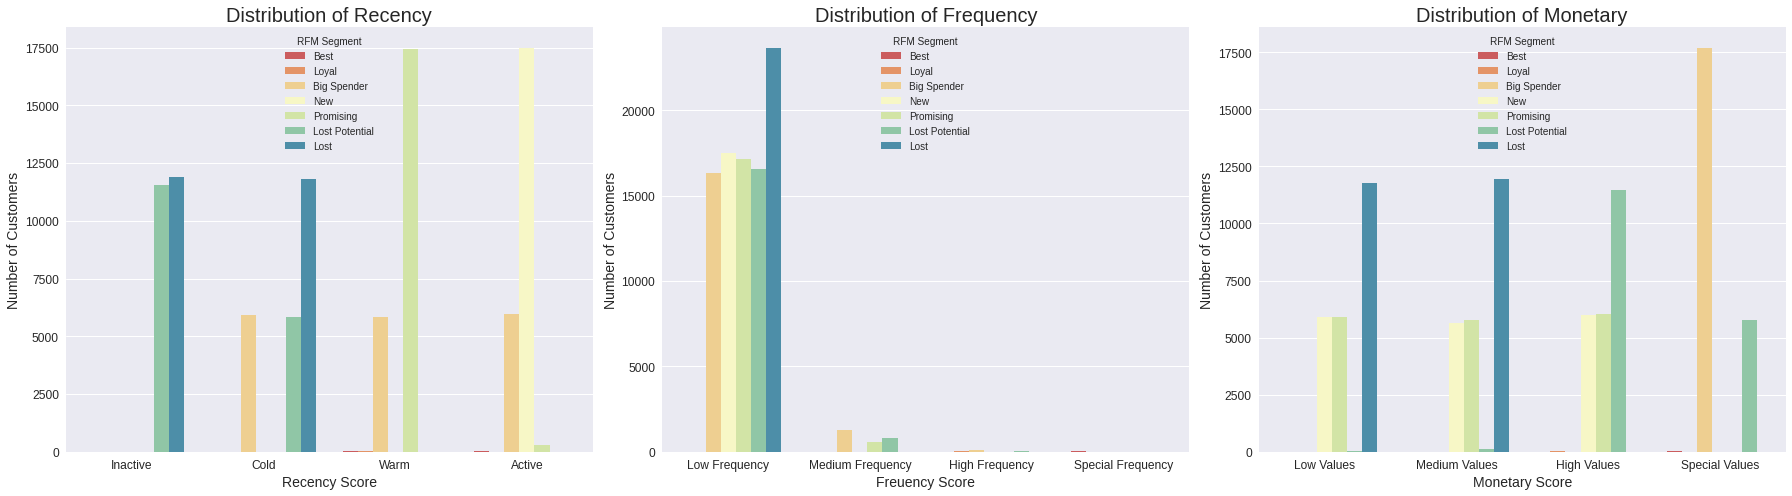

In [ ]:
segment = ['Best', 'Loyal', 'Big Spender', 'New', 'Promising', 'Lost Potential', 'Lost']
# Visualization for Recency, Freuency, Monetary score distribution by Customer Segmentation 2
plt.figure(figsize=(25, 7))

plt.subplot(131)
sns.countplot(x='R', hue='RFM Segment', data=cust_df, hue_order=segment, palette='Spectral')
plt.title('Distribution of Recency',fontsize=20)
plt.xlabel('Recency Score',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(np.arange(4), ['Inactive', 'Cold', 'Warm', 'Active'], fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(132)
sns.countplot(x='F', hue='RFM Segment', data=cust_df, hue_order=segment, palette='Spectral')
plt.title('Distribution of Frequency',fontsize=20)
plt.xlabel('Freuency Score',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(np.arange(4), ['Low Frequency', 'Medium Frequency', 'High Frequency', 'Special Frequency'], fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(133)
sns.countplot(x='M', hue='RFM Segment', data=cust_df, hue_order=segment, palette='Spectral')
plt.title('Distribution of Monetary',fontsize=20)
plt.xlabel('Monetary Score',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(np.arange(4), ['Low Values', 'Medium Values', 'High Values', 'Special Values'], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

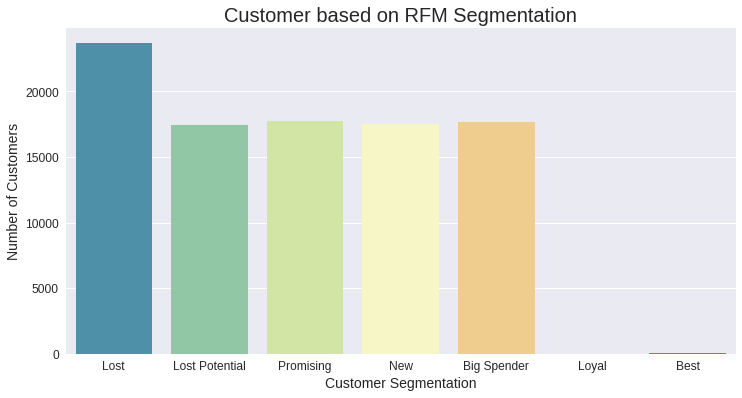

In [ ]:
segment2 = ['Lost', 'Lost Potential', 'Promising', 'New', 'Big Spender', 'Loyal', 'Best']
# Distribution of Customer Segmentation
plt.figure(figsize=(12,6))
sns.countplot(x='RFM Segment', data=cust_df, order=segment2, palette='Spectral_r')
plt.title('Customer based on RFM Segmentation',fontsize=20)
plt.xlabel('Customer Segmentation',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


> 

- Best : Customer yang melakukan transaksi baru-baru ini, sering melakukan transaksi, dan mempunyai total transaksi yang paling tinggi. 
- Loyal : Customer yang sudah melakukan transaksi lebih dari 4 kali. 
- Big Spender : Customer yang melakukan transaksi dengan total transaksi paling tinggi.
- New : Customer yang melakukan transaksi baru-baru ini dan baru bertransaksi sebanyak 1 kali.
- Promising : Customers yang baru-baru ini melakukan transaksi, serta frekuensi dan total transaksinya diatas rata-rata customers lain.
- Lost Potential : Customers yang sudah lama tidak melakukan transaksi, tetapi frekuensi dan total transaksinya diatas rata-rata customers lain.
- Lost : Customers yang sudah lama tidak melakukan transaksi, hanya melakukan satu kali transaksi, dan total transaksi sedikit.

#### Scatter Plot 

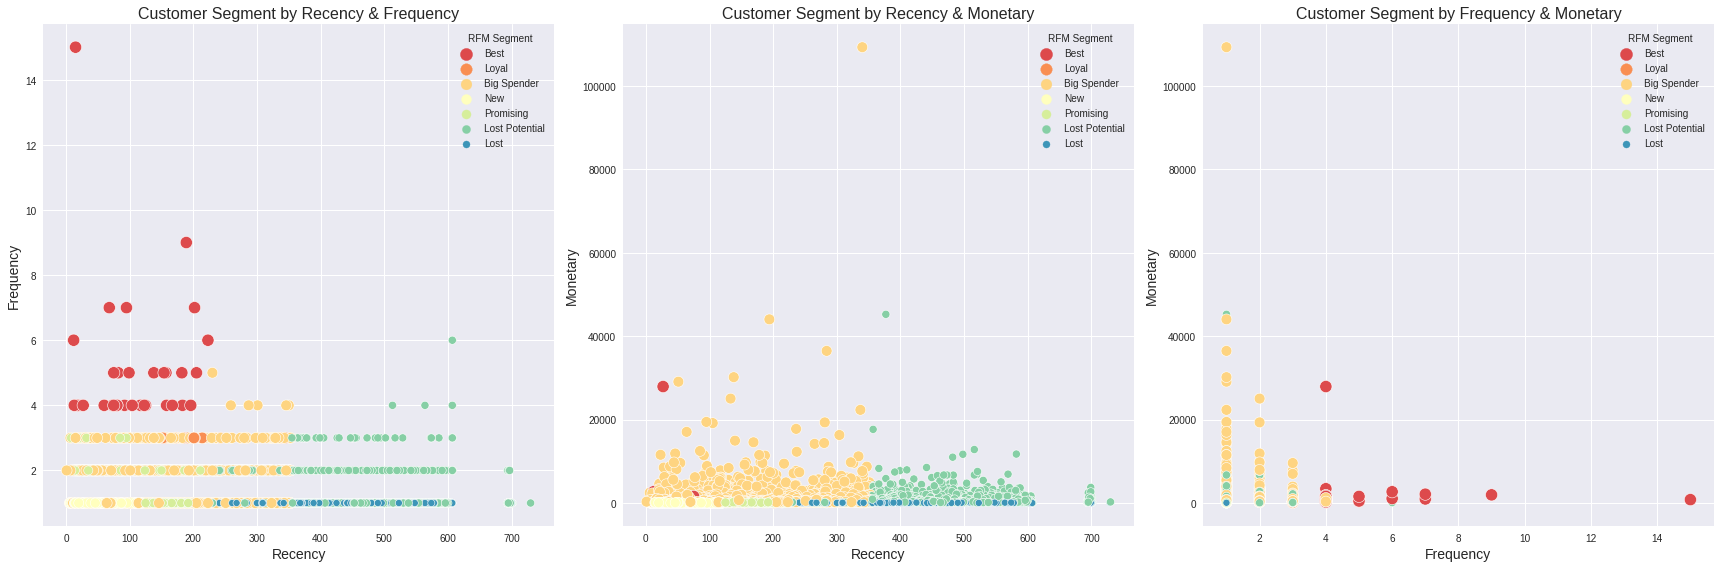

In [ ]:
# Scatter Plot for RFM segmentation 2
plt.figure(figsize=(24,8), facecolor='w')

plt.subplot(131)
sns.scatterplot(x='recency', 
                y='frequency', 
                hue='RFM Segment', 
                data=cust_df, 
                size='RFM Segment', 
                sizes=(50,150), 
                size_order=segment, 
                hue_order=segment, 
                palette='Spectral')
plt.title('Customer Segment by Recency & Frequency',fontsize=16)
plt.xlabel('Recency',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(132)
sns.scatterplot(x='recency', 
                y='monetary', 
                hue='RFM Segment', 
                data=cust_df, 
                size='RFM Segment', 
                sizes=(50,150), 
                size_order=segment,
                hue_order=segment, 
                palette='Spectral')
plt.title('Customer Segment by Recency & Monetary',fontsize=16)
plt.xlabel('Recency',fontsize=14)
plt.ylabel('Monetary',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(133)
sns.scatterplot(x='frequency', 
                y='monetary', 
                hue='RFM Segment', 
                data=cust_df, 
                size='RFM Segment', 
                sizes=(50,150), 
                size_order=segment,
                hue_order=segment,
                palette='Spectral')
plt.title('Customer Segment by Frequency & Monetary',fontsize=16)
plt.xlabel('Frequency',fontsize=14)
plt.ylabel('Monetary',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
def RFM_segmentation_score(x):
    if x == 'Best':
        return 7
    elif x == 'Loyal':
        return 6
    elif x == 'Big Spender':
        return 5
    elif x == 'New':
        return 4
    elif x == 'Promising':
        return 3
    elif x == 'Lost Potential':
        return 2
    else:
        return 1

cust_df['RFM Segment Score'] = cust_df['RFM Segment'].apply(RFM_segmentation_score)

#### 3D Visualization

In [ ]:
fig = px.scatter_3d(cust_df, x = 'recency', y = 'frequency', z = 'monetary', color = 'RFM Segment')
fig.show()

#### Calucalate Silhoutte Score

In [ ]:
# Define x
x = cust_df[['recency', 'frequency', 'monetary']]
# Scale
scaler = StandardScaler()
# Data Scale
x_scaled = scaler.fit_transform(x)
# Calculate Silhoutte Score
labels = cust_df['RFM Segment Score']
silhoutte_value = silhouette_score(x_scaled, labels)
print('Silhoutte Score for RFM:', silhoutte_value)

Silhoutte Score for RFM: 0.11540435946154042


## K-Means:
K-Means merupakan algoritma yang dapat digunakan untuk *clustering*. Algoritma K-Means menggunakan konsep jarak sama seperti algoritma KNN. Salah satu konsep jarak yang digunakan adalah *Euclidean*. Dikarenakan algortima K-Means menggunakan konsep jarak, maka kami harus melakukan *scaling* terhadap *feature* yang kami punya berhubung *feaature* tersebut *scalingnya* tidak sama. *Feature* yang kami punya menunjukkan adanya *outlier* dan kami tidak ingin data *outlier* tersebut memiliki pengaruh sehingga scaling yang dapat digunakan adalah *Standard Scaler*.

In [ ]:
## Data
x = cust_df[['recency', 'frequency', 'monetary']]

# Scale
scaler = StandardScaler()

# Data Scale
x_scaled = scaler.fit_transform(x)

In [ ]:
score = []
number_of_clusters = range(2,9)

for i in number_of_clusters:
  kmeans = KMeans(i)
  kmeans.fit(x_scaled)

  label = kmeans.labels_
  score.append(silhouette_score(x_scaled, label, metric = 'euclidean'))

In [ ]:
for i in range(len(score)):
  print(f'Silhoutte Score untuk {i+2} Cluster', round(score[i], 3))

Silhoutte Score untuk 2 Cluster 0.775
Silhoutte Score untuk 3 Cluster 0.527
Silhoutte Score untuk 4 Cluster 0.529
Silhoutte Score untuk 5 Cluster 0.537
Silhoutte Score untuk 6 Cluster 0.486
Silhoutte Score untuk 7 Cluster 0.492
Silhoutte Score untuk 8 Cluster 0.49


Text(0, 0.5, 'Silhoutte Score')

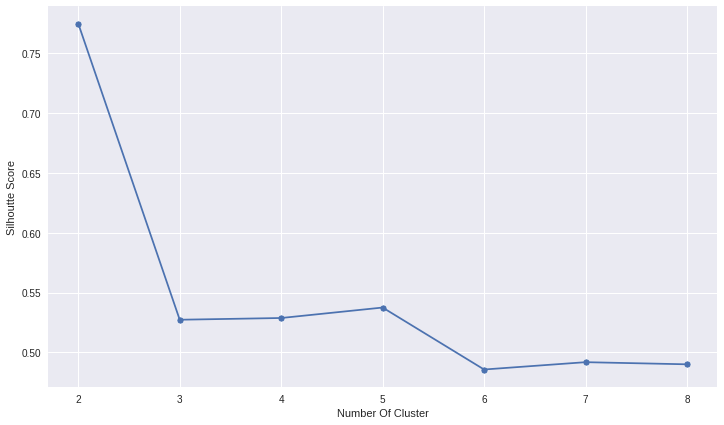

In [ ]:
plt.figure(figsize = (12, 7))

sns.lineplot(number_of_clusters, score)
sns.scatterplot(number_of_clusters, score)

plt.xlabel("Number Of Cluster")
plt.ylabel('Silhoutte Score')

> Keterangan:
- *Silhoutte Score* terbaik didapatkan pada cluster 2
- Kami memutuskan untuk tidak menggunakan 2 *cluster* karena *cluster* yang terbentuk kemungkinan besar hanya *customer* dengan *frequency* 1 kali dengan *monetary* yang rendah dan *customer* diluar *cluster* tersebut
- Kami akan menggunakan 5 *cluster* karena 4 *cluster* memiliki nilai *silhoutte score* tertinggi setelah 2

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=10)
kmeans.fit(x_scaled)

cust_df['label k-means'] = kmeans.labels_

In [ ]:
px.scatter_3d(cust_df, x = 'recency', y = 'frequency', z = 'monetary', color = 'label k-means')

In [ ]:
label = cust_df['label k-means']
score = silhouette_score(x_scaled, label, metric = 'euclidean')
score

0.5368681276748339

In [ ]:
def label(x):
  if x == 0:
    return 'New Comer'
  elif x == 1:
    return 'Lost'
  elif x == 2:
    return 'Big Spender'
  elif x == 3:
    return 'Medium Spender'
  else:
    return 'Loyal'

cust_df['label k-means'] = cust_df['label k-means'].apply(label)

In [ ]:
# Jumlah Customer setiap segment
cust_df['label k-means'].value_counts()

New Comer         52386
Lost              38538
Loyal              2828
Medium Spender      328
Big Spender           7
Name: label k-means, dtype: int64

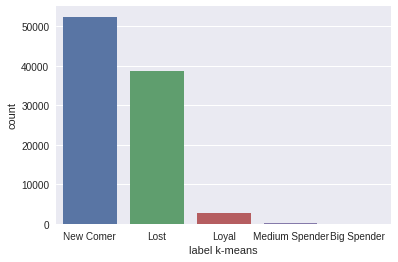

In [ ]:
## Visualisasi
plt.figure(figsize = (6,4))
sns.countplot(x='label k-means', data = cust_df)
plt.show()

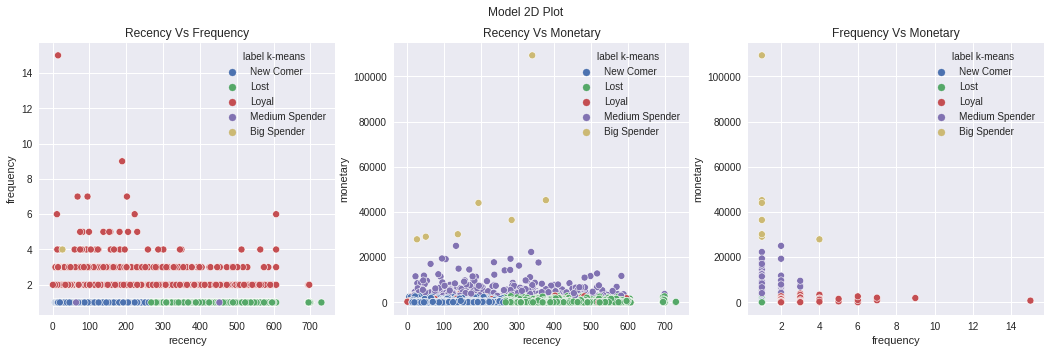

In [ ]:
plt.figure(figsize =(18,5))

# Recency vs Frequency
plt.subplot(131)
sns.scatterplot(x = 'recency', y = 'frequency', hue = 'label k-means', data = cust_df)
plt.title('Recency Vs Frequency')

# Recency Vs Monetary
plt.subplot(132)
sns.scatterplot(x = 'recency', y = 'monetary', hue = 'label k-means', data = cust_df)
plt.title('Recency Vs Monetary')

# Frequency Vs Monetary
plt.subplot(133)
sns.scatterplot(x = 'frequency', y = 'monetary', hue = 'label k-means', data = cust_df)
plt.title('Frequency Vs Monetary')

plt.suptitle('Model 2D Plot')
plt.show()

In [ ]:
px.scatter_3d(cust_df, x = 'recency', y = 'frequency', z = 'monetary', color = 'label k-means')

## Gaussian:
Gaussian merupakan salah satu algoritma *unsupervised learning* yang dapat digunakan untuk *clustering*. Konsep dari algoritma ini adalah menggunakan *Expectation Maximazation (EM)* untuk menentukan *mean* dan *variance* baru. Berikut cara kerja algoritma Gaussian:
1. Menentukan jumlah *cluster* yang ingin dibuat
2. Menentukan nilai *mean* dan *variance* dari setiap *cluster* secara *random*
3. Menghitung *probability* dari setiap data point untuk melihat data tersebut masuk kedalam *cluster* mana dengan menggunakan *Expectation Step*
4. Menentukan nilai *mean* dan *variance* yang baru dengan menggunakan *maximazation Step*
5. Menghitung *log-likelihood* untuk mengecek convergence
6. Mengulang step 3 sampai seterusnya hingga mendapatkan hasil yang stabil

Dikarenakan algoritma ini tidak menggunakan konsep jarak, melainkan menggunakan konsep *EM* maka tidak memerlukan scaling

In [ ]:
x = cust_df[['recency', 'frequency', 'monetary']]

In [ ]:
score2 = []
number_of_clusters = range(2,9)

for i in number_of_clusters:
  gsm = GaussianMixture(n_components=i)
  gsm.fit(x)

  label = gsm.predict(x)
  score2.append(silhouette_score(x_scaled, label, metric = 'euclidean'))

In [ ]:
for i in range(len(score2)):
  print(f'Silhoutte Score untuk {i+2} Cluster', round(score2[i], 3))

Silhoutte Score untuk 2 Cluster 0.689
Silhoutte Score untuk 3 Cluster 0.684
Silhoutte Score untuk 4 Cluster 0.618
Silhoutte Score untuk 5 Cluster 0.222
Silhoutte Score untuk 6 Cluster 0.046
Silhoutte Score untuk 7 Cluster -0.013
Silhoutte Score untuk 8 Cluster 0.136


Text(0, 0.5, 'Silhoutte Score')

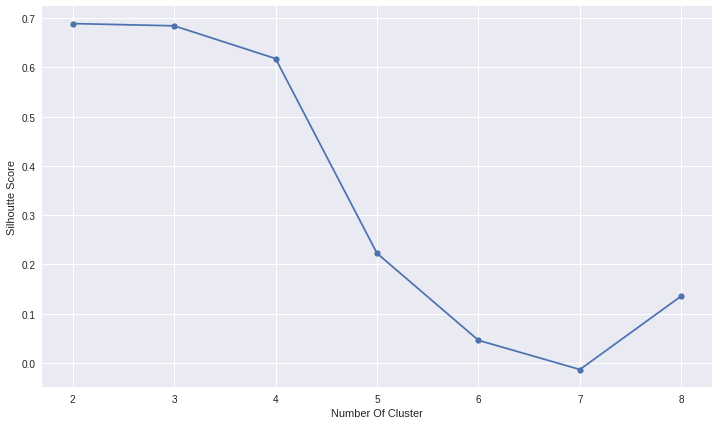

In [ ]:
plt.figure(figsize = (12, 7))

sns.lineplot(number_of_clusters, score2)
sns.scatterplot(number_of_clusters, score2)

plt.xlabel("Number Of Cluster")
plt.ylabel('Silhoutte Score')

In [ ]:
gsm = GaussianMixture(n_components=3)
gsm.fit(x)

cust_df['label gaussian'] = gsm.predict(x)

In [ ]:
px.scatter_3d(cust_df, x = 'recency', y = 'frequency', z = 'monetary', color = 'label gaussian')

In [ ]:
cust_df['label gaussian'].value_counts()

0    88571
1     5515
2        1
Name: label gaussian, dtype: int64

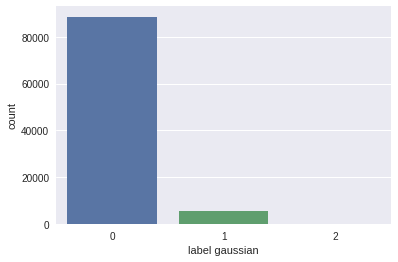

In [ ]:
## Visualisasi
plt.figure(figsize = (6,4))
sns.countplot(x='label gaussian', data = cust_df)
plt.show()

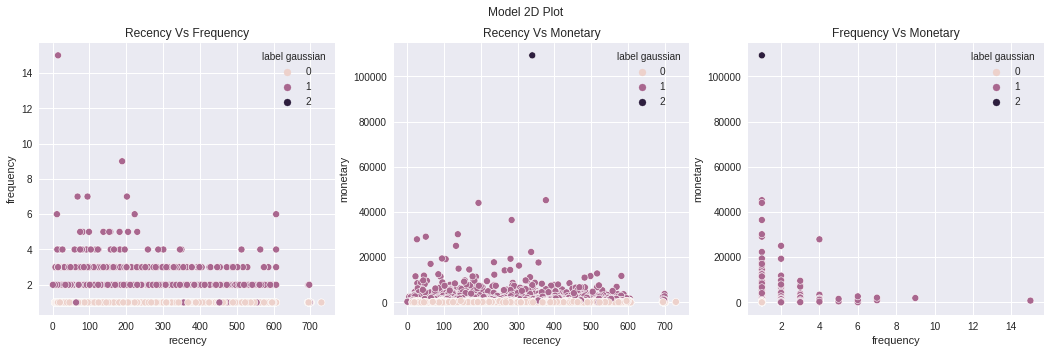

In [ ]:
plt.figure(figsize =(18,5))

# Recency vs Frequency
plt.subplot(131)
sns.scatterplot(x = 'recency', y = 'frequency', hue = 'label gaussian', data = cust_df)
plt.title('Recency Vs Frequency')

# Recency Vs Monetary
plt.subplot(132)
sns.scatterplot(x = 'recency', y = 'monetary', hue = 'label gaussian', data = cust_df)
plt.title('Recency Vs Monetary')

# Frequency Vs Monetary
plt.subplot(133)
sns.scatterplot(x = 'frequency', y = 'monetary', hue = 'label gaussian', data = cust_df)
plt.title('Frequency Vs Monetary')

plt.suptitle('Model 2D Plot')
plt.show()

## RFM Segmentation Analysis:
Tahap selanjutnya adalah menganalisa sifat dari setiap segmentasi agar dapat diberikan treatment yang sesuai dengan sifat tersebut

In [ ]:
# RFM Segmentation Group by for analysis
rfm_segment = cust_df.groupby(['RFM Segment', 'RFM Segment Score']).agg(
    n_customer = ('customer_unique_id', 'count'),
    mean_recency =  ('recency', 'mean'),
    min_recency = ('recency', 'min'),
    max_rencency = ('recency', 'max'),
    mean_freq = ('frequency', 'mean'),
    min_freq = ('frequency', 'min'),
    max_freq = ('frequency', 'max'),
    mean_monetary =  ('monetary', 'mean'),
    min_monetary = ('monetary', 'min'),
    max_monetary = ('monetary', 'max'),
    most_payment_type = ('most_payment_type', lambda x: x.value_counts().index[0]),
    avg_review_score = ('avg_review_score', 'mean'),
    most_product_buy = ('most_product_buy', lambda x: x.value_counts().index[0]),
).sort_values(by='RFM Segment Score', ascending=False)

rfm_segment

n_customer  ...       most_product_buy
RFM Segment    RFM Segment Score              ...                       
Best           7                          37  ...        furniture_decor
Loyal          6                          18  ...        home_appliances
Big Spender    5                       17704  ...          health_beauty
New            4                       17499  ...          health_beauty
Promising      3                       17732  ...  computers_accessories
Lost Potential 2                       17413  ...         bed_bath_table
Lost           1                       23684  ...         bed_bath_table

[7 rows x 13 columns]

> Keterangan :
1. **Best Customers**:
  - Segmen ini terdiri dari 37 *customers*
  - *Customers* dapat dikatakan **Best Customers** melakukan transaksi baru-baru ini, sering melakukan transaksi, dan mempunyai total transaksi yang paling tinggi.
  - Pada segmen ini rata-rata total transaksi tiap customer di sekitar R\$ 1,792 dengan rata-rata frekuensi transaksi 5 kali, dan rata-rata waktu terakhir pembelian sekitar 101 hari.
  - *Customers* pada segmen ini memberikan rata-rata *review score* 4.3
  - Pada segmen ini *customers* paling banyak membeli kategori furniture decoration dengan metode pembayaran credit card.
  - Treatment yang diberikan adalah loyalty program/reward point, rekomendasi produk baru, dan penawaran barang eksklusif. (Cross / Up Selling Strategy)
  
> 2. **Loyal Customers**:
  - Segmen ini terdiri dari 18 *customers*
  - *Customers* yang melakukan transaksi paling sering. 
  - Pada segmen ini rata-rata total transaksi tiap customer di sekitar R\$ 165 dengan rata-rata frekuensi transaksi 3 kali, dan rata-rata waktu terakhir pembelian sekitar 198 hari.
  - *Customers* pada segmen ini memberikan rata-rata *review score* 4.5
  - Pada segmen ini *customers* paling banyak membeli kategori home appliances dengan metode pembayaran credit card.
  - Treatment yang diberikan adalah loyalty program/reward point dan penawaran barang eksklusif (Cross / Up Selling Strategy).

> 3. **Big Spenders Customers**:
  - Segmen ini terdiri dari 17,704 *customers*
  - *Customers* yang mempunya total transaksi paling tinggi.
  - Pada segmen ini rata-rata total transaksi tiap customer di sekitar R\$ 574 dengan rata-rata frekuensi transaksi 1 kali, dan rata-rata waktu terakhir pembelian sekitar 173 hari.
  - *Customers* pada segmen ini memberikan rata-rata *review score* 3.8
  - Pada segmen ini *customers* paling banyak membeli kategori health beauty dengan metode pembayaran credit card.
  - Treatment yang dapat diberikan adalah	rekomendasi barang eksklusif, penawaran partnership/membership (B2B), dan penawaran pembelian dengan harga grosir (Cross / Up Selling Strategy)

> 4. **New Customers**:
  - Segmen ini terdiri dari 17,499 *customers*
  - *Customers* yang baru-baru ini melakukan transaksi dan baru satu kali melakukan transaksi.
  - Pada segmen ini rata-rata total transaksi tiap customer di sekitar R\$ 94 dengan rata-rata frekuensi transaksi 1 kali, dan rata-rata waktu terakhir pembelian sekitar 62 hari.
  - *Customers* pada segmen ini memberikan rata-rata *review score* 4.2
  - Pada segmen ini *customers* paling banyak membeli kategori health beauty dengan metode pembayaran credit card.
  - Treatment yang dapat diberikan adalah welcome e-mail untuk membangun reletionship, penawaran loyalty program/reward point, dan voucher diskon (Cross / Up Selling Strategy)

> 5. **Promising Customers**:
  - Segmen ini terdiri dari 17,732 *customers*
  - *Customers* yang baru-baru ini melakukan transaksi, serta frekuensi dan total transaksinya diatas rata-rata customers lain.
  - Pada segmen ini rata-rata total transaksi tiap customer di sekitar R\$ 94 dengan rata-rata frekuensi transaksi 1 kali, dan rata-rata waktu terakhir pembelian sekitar 170 hari.
  - *Customers* pada segmen ini memberikan rata-rata *review score* 4
  - Pada segmen ini *customers* paling banyak membeli kategori computer accesories dengan metode pembayaran credit card.
  - Treatment yang dapat diberikan adalah penawaran terbatas secara rutin, voucher diskon dan cashback via e-mail (Retention Strategy)

> 6. **Lost Potential Customers**:
  - Segmen ini terdiri dari 17,413 *customers*
  - *Customers* yang sudah lama tidak melakukan transaksi, tetapi frekuensi dan total transaksinya diatas rata-rata customers lain.
  - Pada segmen ini rata-rata total transaksi tiap customer di sekitar R\$ 286 dengan rata-rata frekuensi transaksi 1 kali, dan rata-rata waktu terakhir pembelian sekitar 400 hari.
  - *Customers* pada segmen ini memberikan rata-rata *review score* 4
  - Pada segmen ini *customers* paling banyak membeli kategori bad bath table dengan metode pembayaran credit card.
  - Treatment yang dapat diberikan adalah penawaran terbatas secara rutin, voucher diskon dan cashback via e-mail (Retention & Reactivate Stretegies)

> 7. **Lost Customers**:
  - Segmen ini terdiri dari 23,684 *customers*
  - *Customers* yang sudah lama tidak melakukan transaksi, hanya melakukan satu kali transaksi, dan total transaksi sedikit.
  - Pada segmen ini rata-rata total transaksi tiap customer di sekitar R\$ 65 dengan rata-rata frekuensi transaksi 1 kali, dan rata-rata waktu terakhir pembelian sekitar 370 hari.
  - *Customers* pada segmen ini memberikan rata-rata *review score* 4.1
  - Pada segmen ini *customers* paling banyak membeli kategori bad bath table dengan metode pembayaran credit card.
  - Treatment yang dapat diberikan adalah campaign via e-mail dan meminta feedback. (Reactivation Strategy)

> # Conclusion:
- Berdasarkan 3 model tersebut, setiap model memiliki kelemahan dan keunggulannya tersendiri:
  1. RFM Segmentation:
  - Advantages:
    - Model ini merupakan model yang memiliki interpretasi paling tinggi dibandingkan model lain, karena model ini dibuat dengan *domain knowledge* yang kami punya
  - Disadvantages:
    - Apabila diukur secara kuantitatif dengan silhoutte score, model ini merupakan model yang paling rendah
  2. K-Means:
  - Advantages:
    - Model K-Means merupakan model yang secara visualisasi tidak terlalu buruk dan secara silhoutte score tidak terlalu buruk juga
  - Disadvantages:
    - Pada segmentasi model K-Means, ada beberapa *customer* yang segmentasinya kurang spesifik, karena jumlah *cluster* hanya ditentukan dari Silhoutte Score
  3. Gaussians:
  - Advantages:
    - Model Gaussians secara kuantitatif merupakan model yang paling bagus
  - Disadvantages:
    - Model ini merupakan model yang paling sulit untuk diinterpretasi karena segmentasi dari hasil model ini tidak terlihat jelas

> - Berdasarkan point di atas, kami memutuskan untuk menggunakan model *RFM Segmentation* karena model ini merupakan model yang memiliki interpretasi yang paling tinggi.
- Model *RFM Segmentation* membagi *cluster* menjadi 7 *cluster*, Best, Loyal, Big Spender, New, Promising, Lost Potential, dan Lost

# Business Recommendation:

| RFM Segment    | Deskripsi                                                                                                                       | Strategi                                                             |
|----------------|---------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------|
| Best           | Customers yang melakukan transaksi baru-baru ini, sering melakukan transaksi, dan mempunyai total transaksi yang paling tinggi. |  Loyalty program/reward point, rekomendasi produk baru, dan penawaran barang eksklusif (Cross / Up Selling Strategy)           |
| Loyal          | Customers yang melakukan transaksi paling sering.                                                                               |  Loyalty program/reward point dan penawaran barang eksklusif (Cross / Up Selling Strategy)         |
| Big Spender    | Customers yang mempunya total transaksi paling tinggi.                                                       | Rekomendasi barang eksklusif, penawaran partnership/membership (B2B), dan penawaran pembelian dengan harga grosir (Cross / Up Selling Strategy)                |
| New            | Customers yang baru-baru ini melakukan transaksi dan baru satu kali melakukan transaksi.                                        | Welcome e-mail untuk membangun reletionship, penawaran loyalty program/reward point, dan voucher diskon (Cross / Up Selling Strategy) |
| Promising      | Customers yang baru-baru ini melakukan transaksi, serta frekuensi dan total transaksinya diatas rata-rata customers lain.       |  Penawaran terbatas secara rutin, voucher diskon dan cashback via e-mail (Retention Strategy)                       |
| Lost Potential | Customers yang sudah lama tidak melakukan transaksi, tetapi frekuensi dan total transaksinya diatas rata-rata customers lain.   | Penawaran terbatas secara rutin, voucher diskon dan cashback via e-mail (Retention & Reactivate Stretegies)                   |
| Lost           | Customers yang sudah lama tidak melakukan transaksi, hanya melakukan satu kali transaksi, dan total transaksi sedikit.          | Campaign via e-mail dan meminta feedback. (Reactivation Strategy)                                            |

# Suggestion:
Untuk meningkatkan project ini, kedepannya kami dapat melakukan hal beberapa hal berikut:
1. Model *customer segmentation* yang sudah dibuat dapat diterapkan dalam dunia nyata agar dapat mengetahui besarnya impact model terhadap dunia nyata
1. Riset lebih lanjut mengenai RFM Segmentation agar hasil dari *customer segmentation* dapat lebih terlihat jelas
1. RFM Segmentation dapat dimanfaatkan untuk memaksimalkan metode *e-mail marketing*, meningkatkan *customers lifetime value*, meminimalkan biaya *marketing*, dan meningkatkan *Return of Investment*